In [1]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from sklearn.metrics import pairwise_distances
plt.rcParams['figure.figsize'] = (11, 5)

In [2]:
def euclidianDistance(oneBin, secondBin):
    return np.sum(np.square(oneBin - secondBin)), "Euclidian Distance"


def cosineDistance(oneBin, secondBin):
    return (
        1 - np.sum(np.square(oneBin * secondBin))
            / (np.sqrt(np.sum(np.square(oneBin))) * np.sqrt(sum(np.square(secondBin)))),
            "Cosine Distance",
    )

def kullbackLeibler(oneBin, secondBin):
        return np.sum(oneBin * np.log(oneBin / secondBin)), "Kullback-Leiber"

In [3]:
def detect_Time_Signature(song, path, number):
    hop_length = 512
    sample, sr = librosa.load(path)
    duration = np.arange(len(sample)) / sr
    
    tempo, beats = librosa.beat.beat_track(y=sample, sr=sr)

    # %% Calculate beat duration
    beatDurationSec = 60 / tempo
    beatDurationSample = int(beatDurationSec * sr)

    # %% target spectrogram
    spectrogram, frequencies, times, im = plt.specgram(
        sample,
        Fs=sr,
        NFFT=int(beatDurationSample),
        noverlap=int(beatDurationSample / number),
        mode="magnitude",
    )
    mfcc = librosa.feature.mfcc(y=sample, sr=sr, hop_length=int(beatDurationSample / number), n_mfcc=11)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    new_mfcc = np.concatenate((mfcc, mfcc_delta, mfcc_delta2))
    mfcc = librosa.feature.inverse.mfcc_to_mel(new_mfcc, n_mels=128, dct_type=2, norm='ortho', ref=1.0, lifter=0)
 
    binsAmount = len(beats)
    asm = np.zeros((binsAmount, binsAmount))

    for x in range(binsAmount):
        thisBin = mfcc[:, x]
        for y in range(binsAmount):
            comparedBin = mfcc[:, y]
            asm[x, y], method = euclidianDistance(thisBin, comparedBin)
            #asm[x, y], method = cosineDistance(thisBin, comparedBin)
            #asm[x, y], method = kullbackLeibler(thisBin, comparedBin)
            
    matrixLength = len(asm)
    d = np.zeros(matrixLength)
    for i in range(matrixLength):
        d[i] = np.average(np.diag(asm, i))

    # %% Calculate second function d
    for i in range(matrixLength):
        d[i] = -d[i] + np.max(np.abs(d))
        
    highestMeterNumerator = 6
    lt = int(len(asm) / highestMeterNumerator)
    t = np.zeros(highestMeterNumerator)
    for c in range(2, highestMeterNumerator, 1):
        for p in range(1, lt, 1):
            t[c] += (d[p * c]) / (1 - ((p - 1) / lt))

    t[0] = 0
    t[1] = 0

    # %% detect metre
    metre = np.argmax(t)
    return metre

In [4]:
def read_dataset():
    data = pandas.read_csv(
        "genres_tempos.csv",
        sep=",",
        names=["path", "tempo", "metre", "alt_metre","metre3", "meter4", "performer", "title"],
    )
    return data

def read_dataset_only_metre():
    data = read_dataset()
    data = data[data.metre.notnull()]
    return data

In [5]:
def calculate_accuracy(number):
    data = read_dataset_only_metre()
    count = 0
    for index, row in data.iterrows():
        song = row
        path = song.path
        path = os.path.relpath("Data/genres_original" + path)
        metre = detect_Time_Signature(song, path, number)
        if metre == song.metre or metre == song.alt_metre:
            count += 1

    accuracy = (count / len(data)) * 100
    return accuracy

# accuracy = calculate_accuracy(8)
# print(accuracy)

/Users/pianistprogrammer/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7725: RuntimeWarning: divide by zero encountered in log10
  Z = 20. * np.log10(spec)


for 2, the accuracy is  61.60520607375272 
for 4, the accuracy is  66.70281995661605 
for 6, the accuracy is  35.68329718004338 
for 8, the accuracy is  66.5943600867679 
for 10, the accuracy is  30.151843817787416 
for 12, the accuracy is  44.143167028199564 
for 14, the accuracy is  44.90238611713666 
for 16, the accuracy is  52.603036876355745 


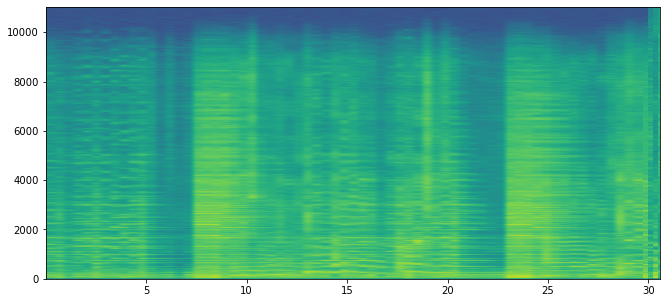

In [6]:
for x in range(2, 18, 2):
    accuracy = calculate_accuracy(x)
    print("for {}, the accuracy is  {} ".format(x, accuracy))
